Ta# sk 1: Exploratory Data Analysis and Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import os 
import sys
sys.path.append(os.path.abspath("../src"))
import warnings
warnings.filterwarnings('ignore')

In [2]:
# %%
os.chdir("..")  # Go up a directory
#print(os.getcwd())

Perform Initial EDA

In [3]:
from EDA_Preprocessing import load_data
df = load_data("Data/complaints.csv")


🔹 Chunk 1 - First 5 Rows:
  Date received                                            Product  \
0    2025-06-20  Credit reporting or other personal consumer re...   
1    2025-06-20                                    Debt collection   
2    2025-06-20  Credit reporting or other personal consumer re...   
3    2025-06-20  Credit reporting or other personal consumer re...   
4    2025-06-20  Credit reporting or other personal consumer re...   

               Sub-product                                 Issue  \
0         Credit reporting  Incorrect information on your report   
1  Telecommunications debt     Attempts to collect debt not owed   
2         Credit reporting           Improper use of your report   
3         Credit reporting           Improper use of your report   
4         Credit reporting  Incorrect information on your report   

                                       Sub-issue Consumer complaint narrative  \
0            Information belongs to someone else              

In [5]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
200000,2025-06-02,Credit reporting or other personal consumer re...,Credit reporting,Problem with a company's investigation into an...,Their investigation did not fix an error on yo...,NaN,NaN,"Colony Brands, Inc.",TX,78232,NaN,NaN,Web,2025-06-02,Closed with explanation,Yes,NaN,13847543
200001,2025-05-29,Debt collection,I do not know,False statements or representation,Attempted to collect wrong amount,NaN,NaN,"ONLINE Information Services, Inc.",TX,77024,Servicemember,NaN,Web,2025-05-29,Closed with non-monetary relief,Yes,NaN,13795621
200002,2025-05-30,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,Experian Information Solutions Inc.,TX,75052,NaN,NaN,Web,2025-05-30,In progress,Yes,NaN,13808564
200003,2025-06-03,Credit reporting or other personal consumer re...,Credit reporting,Problem with a company's investigation into an...,Their investigation did not fix an error on yo...,NaN,NaN,"EQUIFAX, INC.",TX,77449,NaN,NaN,Web,2025-06-11,In progress,Yes,NaN,13868064
200004,2025-06-04,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Account information incorrect,NaN,NaN,Experian Information Solutions Inc.,TX,78753,NaN,NaN,Web,2025-06-04,In progress,Yes,NaN,13883738


In [6]:
df.head()
df.shape

(100000, 18)

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')
Date received                   object
Product                         object
Sub-product                     object
Issue                           object
Sub-issue                       object
Consumer complaint narrative    object
Company public response         object
Company                         object
State                           object
ZIP code                        object
Tags                            object
Consumer consent provided?      object
Submitted via                   object
Date sent to company            object
Company response to consumer    object
Timely response?                

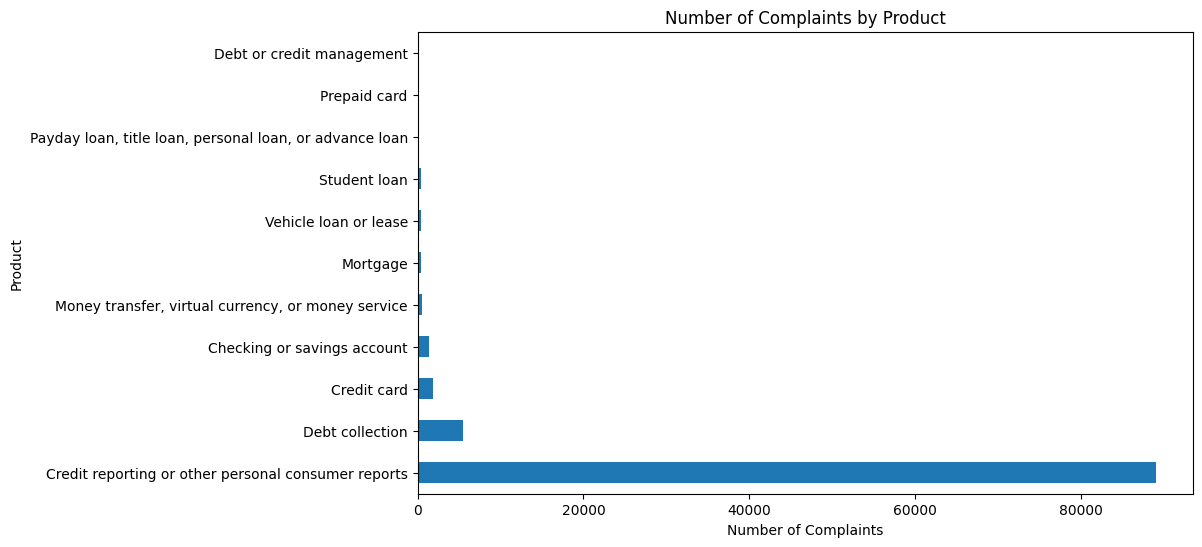

In [7]:
# Show basic structure
print(df.columns)
print(df.dtypes)
print(df.isna().sum())

# Distribution of complaints by Product
plt.figure(figsize=(10, 6))
df['Product'].value_counts().plot(kind='barh')
plt.title('Number of Complaints by Product')
plt.xlabel('Number of Complaints')
plt.show()

Analyze Complaint Narrative Length

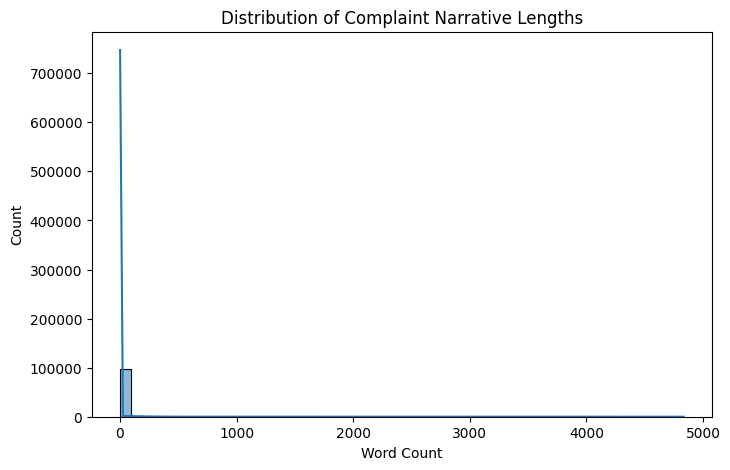

 Very short narratives (<10 words): 96591
 Very long narratives (>500 words): 158


In [8]:
df['narrative_length'] = df['Consumer complaint narrative'].astype(str).apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 5))
sns.histplot(df['narrative_length'], bins=50, kde=True)
plt.title('Distribution of Complaint Narrative Lengths')
plt.xlabel('Word Count')
plt.show()

# Short and long narratives
print(" Very short narratives (<10 words):", (df['narrative_length'] < 10).sum())
print(" Very long narratives (>500 words):", (df['narrative_length'] > 500).sum())

Count Complaints With vs Without Narrative

In [9]:
with_narrative = df['Consumer complaint narrative'].notna().sum()
without_narrative = df['Consumer complaint narrative'].isna().sum()

print(f" Complaints with narratives: {with_narrative}")
print(f" Complaints without narratives: {without_narrative}")

 Complaints with narratives: 3413
 Complaints without narratives: 96587


Filter Dataset for Specified Products & Clean Narratives

In [10]:
TARGET_PRODUCTS = [
    "Credit card", 
    "Personal loan", 
    "Buy Now, Pay Later (BNPL)", 
    "Savings account", 
    "Money transfer, virtual currency, or money service"
]

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\bi am writing.*?complaint\b', '', text)  # remove boilerplate
    text = re.sub(r'[^a-z0-9\s]', '', text)  # remove special characters
    text = re.sub(r'\s+', ' ', text)  # normalize whitespace
    return text.strip()

def filter_and_clean(df):
    filtered = df[df['Product'].isin(TARGET_PRODUCTS)].copy()
    filtered = filtered[filtered['Consumer complaint narrative'].notna()]
    filtered['cleaned_narrative'] = filtered['Consumer complaint narrative'].apply(clean_text)
    return filtered

filtered_df = filter_and_clean(df)
print(f"Filtered data shape: {filtered_df.shape}")

Filtered data shape: (286, 20)


Save Cleaned Dataset

In [11]:
def save_filtered_data(df, path="Data/filtered_complaints.csv"):
    try:
        os.makedirs(os.path.dirname(path), exist_ok=True)
        df.to_csv(path, index=False)
        print(f" Filtered dataset saved to {path}")
    except Exception as e:
        print(f" Failed to save file: {e}")

save_filtered_data(filtered_df)

 Filtered dataset saved to Data/filtered_complaints.csv


In [12]:
df_clean = pd.read_csv("Data/filtered_complaints.csv")
df_clean.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,narrative_length,cleaned_narrative
0,2025-05-24,Credit card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute ...,"On XX/XX/XXXX, I paid a one-time refundable de...",Company has responded to the consumer and the ...,"BANK OF AMERICA, NATIONAL ASSOCIATION",CA,91770,NaN,Consent provided,Web,2025-05-24,Closed with monetary relief,Yes,NaN,13682596,359,on xxxxxxxx i paid a onetime refundable deposi...
1,2025-06-10,Credit card,Store credit card,Problem when making payments,Problem during payment process,On XX/XX/XXXX I received a notification from X...,Company believes it acted appropriately as aut...,Atlanticus Services Corporation,MD,21202,Servicemember,Consent provided,Web,2025-06-10,Closed with monetary relief,Yes,NaN,13988034,314,on xxxxxxxx i received a notification from xxx...
2,2025-03-13,"Money transfer, virtual currency, or money ser...",Domestic (US) money transfer,Money was not available when promised,NaN,Used Moneygram to send {$1800.00} to my landlo...,NaN,MONEYGRAM PAYMENT SYSTEMS WORLDWIDE INC,MT,598XX,NaN,Consent provided,Web,2025-03-13,Closed with explanation,Yes,NaN,12458954,259,used moneygram to send 180000 to my landlord o...
3,2025-05-23,Credit card,General-purpose credit card or charge card,Closing your account,Company closed your account,Wells Fargo let XXXX XXXX transactions dispute...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,FL,33805,NaN,Consent provided,Web,2025-05-23,Closed with explanation,Yes,NaN,13681010,22,wells fargo let xxxx xxxx transactions dispute...
4,2025-05-30,Credit card,General-purpose credit card or charge card,Trouble using your card,Can't use card to make purchases,XXXX and XXXX XXXX XXXX XXXX XXXX XXXX XXXX. \...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",FL,33432,NaN,Consent provided,Web,2025-05-30,Closed with non-monetary relief,Yes,NaN,13775029,672,xxxx and xxxx xxxx xxxx xxxx xxxx xxxx xxxx xx...


In [13]:
df_clean.shape

(286, 20)